<h1>Parameter Tuning and Select Best Model</h1>

Michael Trofimov and Seymone Gugneja

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

In [56]:
#Example: Predicting Bike Traffic

In [57]:
import pandas as pd
# these two files are large, and it may take a while to read...
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [58]:
#Next we will compute the total daily bicycle traffic, and put this in its own dataframe:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [59]:
# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [60]:
#Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:
# 
#add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

(8, 17)

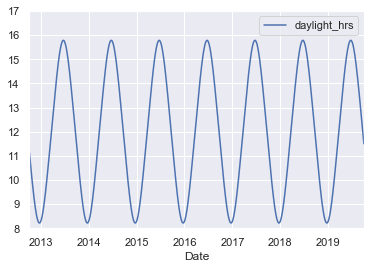

In [61]:
# 
#add an indicator about daylight_hrs
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [62]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')

daily[:5]

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0


In [63]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [64]:
# -- Linear Regression
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

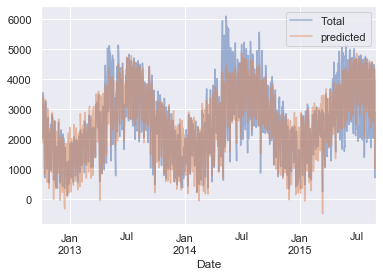

In [65]:
# a little bit different than our previous example
# this plot is from pandas
daily[['Total', 'predicted']].plot(alpha=0.5);

In [66]:
# the estimated beta0 to betan
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

In [67]:
import matplotlib.pyplot as plt

daily[:5]
daily.corr(method='spearman')


,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Total,1.000000,0.147496,0.200247,0.186168,0.142324,0.054430,-0.360151,-0.370513,-0.111138,0.619644,-0.465832,0.620759,0.429007,0.235085,0.932395
Mon,0.147496,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,0.195584,0.000402,-0.025984,0.019147,0.017129,0.002658,0.143697
Tue,0.200247,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.018851,0.000651,0.006232,0.004420,-0.010122,0.003987,0.212646
Wed,0.186168,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.035347,-0.000586,0.005944,-0.011469,0.000779,-0.003987,0.197020
Thu,0.142324,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,0.030634,-0.000407,0.010861,-0.001675,-0.015572,-0.002658,0.140759
Fri,0.054430,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.035347,-0.000240,0.026654,0.000109,-0.037373,-0.001329,0.033788
Sat,-0.360151,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.068337,-0.000044,-0.017684,-0.005938,0.028030,0.000000,-0.356990
Sun,-0.370513,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.068337,0.000223,-0.006022,-0.004595,0.017129,0.001329,-0.370920
holiday,-0.111138,0.195584,-0.018851,-0.035347,0.030634,-0.035347,-0.068337,-0.068337,1.000000,-0.078683,-0.050033,-0.068670,0.059115,-0.027033,-0.130353
daylight_hrs,0.619644,0.000402,0.000651,-0.000586,-0.000407,-0.000240,-0.000044,0.000223,-0.078683,1.000000,-0.309824,0.790926,0.307482,0.251389,0.686755


In [68]:
#tune alpha for lasso and ridge using randomized search cv

/Users/seymonegugneja/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/seymonegugneja/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 606036.1303123832, tolerance: 113263.32732863189
  positive)
/Users/seymonegugneja/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560743.2174960226, tolerance: 102219.53132411848
  positive)
/Users/seymonegugneja/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not co

Lasso Regression highest accuracy: 0.8286207680761375


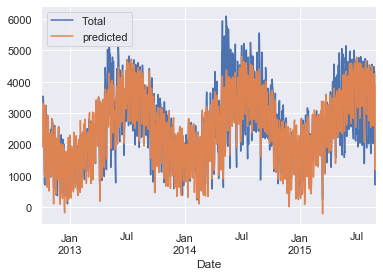

In [69]:
#lasso regression
from sklearn.linear_model import Lasso

lassoModel = Lasso()
paramGrid = {'alpha': np.arange(0,10,0.1)}
lassoGrid = RandomizedSearchCV(estimator=lassoModel, param_distributions=paramGrid, n_iter=10)
lassoGrid.fit(X,y)

daily['predicted'] = lassoGrid.predict(X)
daily[['Total', 'predicted']].plot();

#fit data to model and plot on graph
print('Lasso Regression highest accuracy: ' + str(lassoGrid.best_score_))

/Users/seymonegugneja/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Ridge Regression highest accuracy: 0.8221945737019958


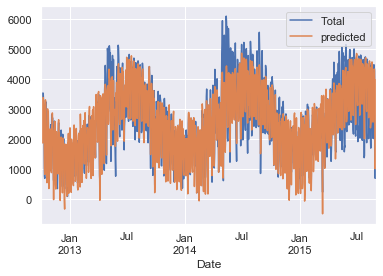

In [70]:
#ridge regression
from sklearn.linear_model import Ridge

ridgeModel = Ridge()
paramGrid = {'alpha': np.arange(0,10,0.1)}
ridgeGrid = RandomizedSearchCV(estimator=ridgeModel, param_distributions=paramGrid, n_iter=10)
ridgeGrid.fit(X,y)

daily['predicted'] = ridgeGrid.predict(X)
daily[['Total', 'predicted']].plot();

#fit data to model and plot on graph
print('Ridge Regression highest accuracy: ' + str(ridgeGrid.best_score_))

In [71]:
#Linear Regression
from sklearn.model_selection import cross_validate

lrModel = LinearRegression()
lrResults = cross_validate(lrModel, X, y, cv=10)

print('Linear Regression highest accuracy: ' + str(lrResults))

Linear Regression highest accuracy: {'fit_time': array([0.00483489, 0.00341821, 0.00302196, 0.00254321, 0.00359607,
       0.00292826, 0.00304365, 0.0021472 , 0.00212097, 0.00253296]), 'score_time': array([0.0046761 , 0.00219989, 0.00143003, 0.00114989, 0.00128317,
       0.00153971, 0.00128627, 0.00114393, 0.00136018, 0.0010519 ]), 'test_score': array([0.76236871, 0.74794215, 0.77221239, 0.84538276, 0.7355564 ,
       0.76066698, 0.82227323, 0.74830747, 0.7751928 , 0.72185004])}


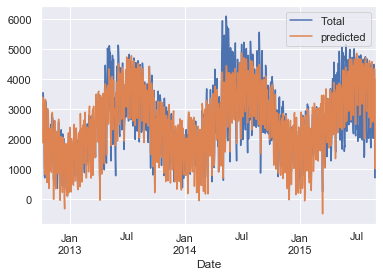

In [72]:
#fit data to model and plot on graph
lrModel.fit(X,y)
daily['predicted'] = lrModel.predict(X)
daily[['Total', 'predicted']].plot(alpha=1);

In [74]:
#get best accuracy
bestAccuracy = max(lrResults)
print('Linear Regression best accuracy: ' + str(bestAccuracy))
testBestAccuracy = max(lrResults['test_score'])
print(testBestAccuracy)

Linear Regression best accuracy: test_score
0.8453827595922792


In [80]:
#Which model performs the best
bestModel = []
bestModel.append(str(lassoGrid.best_score_))
bestModel.append(str(ridgeGrid.best_score_))
bestModel.append(testBestAccuracy)

print(bestModel)
#The model that performs the best is the linear regression model

['0.8286207680761375', '0.8221945737019958', 0.8453827595922792]
